In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
Layer=keras.layers.Layer

class Time2Vector(Layer): #Time embedding layer
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)
class SingleAttention(Layer): #Attention layer
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = tf.keras.layers.Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.key = tf.keras.layers.Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.value = tf.keras.layers.Dense(self.d_v, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out 

class MultiAttention(Layer): #Multihead attention
  def __init__(self, d_k, d_v, n_heads,filt_dim):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.filt_dim=filt_dim
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    self.linear = tf.keras.layers.Dense(self.filt_dim, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

class TransformerEncoder(Layer): #Combining everything into a Transformer encoder
  def __init__(self, d_k, d_v, n_heads, ff_dim,filt_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.filt_dim=filt_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads,self.filt_dim)
    self.attn_dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.attn_normalize = tf.keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = tf.keras.layers.Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    self.ff_conv1D_2 = tf.keras.layers.Conv1D(filters=self.filt_dim, kernel_size=1) # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.ff_dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.ff_normalize = tf.keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

In [2]:
import deeptrack as dt
IMAGE_SIZE=64
sequence_length=10#Number of frames per sequence
MIN_SIZE=.5e-6
MAX_SIZE=1.5e-6
MAX_VEL=10 #Maximum velocity. The higher the trickier!
MAX_PARTICLES=3 #Max number of particles in each sequence. The higher the trickier!

#Defining properties of the particles
particle=dt.Sphere(intensity=lambda: 10+10*np.random.rand(),
                   radius=lambda: MIN_SIZE+np.random.rand()*(MAX_SIZE-MIN_SIZE),
                   position=lambda: IMAGE_SIZE*np.random.rand(2),vel=lambda: MAX_VEL*np.random.rand(2),
                   position_unit="pixel")

#Defining an update rule for the particle position
def get_position(previous_value,vel):

    newv=previous_value+vel
    for i in range(2):
        if newv[i]>63:
            newv[i]=63-np.abs(newv[i]-63)
            vel[i]=-vel[i]
        elif newv[i]<0:
            newv[i]=np.abs(newv[i])
            vel[i]=-vel[i]
    return newv

particle=dt.Sequential(particle,position=get_position)

#Defining properties of the microscope
optics=dt.Fluorescence(NA=1,output_region= (0, 0,IMAGE_SIZE, IMAGE_SIZE), 
    magnification=10,
    resolution=(1e-6, 1e-6),
    wavelength=633e-9)

#Combining everything into a dataset. 
#Note that the sequences are flipped in different directions, so that each unique sequence defines
#in fact 8 sequences flipped in different directions, to speed up data generation
dataset=dt.FlipUD(dt.FlipDiagonal(dt.FlipLR(dt.Sequence(optics(particle**(lambda: 1+np.random.randint(MAX_PARTICLES))),sequence_length=sequence_length))))


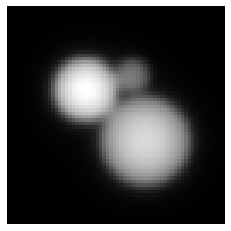

In [13]:
dataset.update().plot(cmap="gray") #This generates a new sequence and plots it
video=dataset.update().resolve() #This generates a new sequence and stores in in "video"

**Data processing**

In [3]:
def get_data(data_amount):
  frames = []

  for _ in range(data_amount):
    video = dataset.update().resolve() # Get a new sequence of frames
    for frame in video:
      frames.append(frame)

  return tf.stack(frames)

data_amount = 100
# Generate new data and save to file
#ball_data = get_data(data_amount)
#np.save('long_ball_data.npy', ball_data)

ball_data = np.load('ball_data.npy') # Load already generated data

**TASK 1**

In [6]:
#neck_width = 256 # for 16 filters in the last convolutional layer in encoder
#filters = 16 
#neck_width = 128 # for 8 filters in the last convolutional layer in encoder
#filters = 8
neck_width = 64 # for 4 filters in the last convolutional layer in encoder
filters = 4

class Autoencoder(tf.keras.Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
      tf.keras.layers.Conv2D(64, (8, 8), padding='same', strides=(4, 4), activation='relu'),
      tf.keras.layers.Conv2D(filters, (4, 4), padding='same', strides=(4, 4), activation='relu'),
      tf.keras.layers.Flatten()
    ])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(neck_width, )),
      tf.keras.layers.Reshape(target_shape=(4, 4, filters)),
      tf.keras.layers.Conv2DTranspose(filters, (4, 4), strides=(4, 4), activation='relu', padding='same'),
      tf.keras.layers.Conv2DTranspose(64, (8, 8), strides=(4, 4), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(1, (1, 1), activation='linear', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.encoder.build(input_shape=(None, 64, 64, 1))
autoencoder.encoder.summary()

autoencoder.decoder.build(input_shape=(None, neck_width))
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4160      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 4)           4100      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
Total params: 8,260
Trainable params: 8,260
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 4, 4, 4)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (N

In [4]:
n_frames = len(ball_data) 
ratio = 0.8 # training data to validation/test data ratio
train_val_split = [int(n_frames*ratio), n_frames-int(n_frames*ratio)]

x_train, x_val = tf.split(ball_data, train_val_split)

max_val = tf.reduce_max(tf.concat([x_train, x_val], 0))
x_train /= max_val
x_val /= max_val

print("Training data size:", x_train.shape)
print("Validation data size:", x_val.shape)


Training data size: (8000, 64, 64, 1)
Validation data size: (2000, 64, 64, 1)


Train

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            min_delta=0,
                                            patience=3,
                                            verbose=1,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=True)
autoencoder.fit(x_train, x_train,
                 batch_size=32,
                 epochs=50,
                 shuffle=True,
                 validation_data=(x_val, x_val),
                 callbacks=[callback])

autoencoder.save('autoencoder_'+str(neck_width))

Epoch 1/50
250/250 [==============================] - 29s 117ms/step - loss: 4.4395e-04 - val_loss: 4.1980e-04
Epoch 2/50
250/250 [==============================] - 28s 112ms/step - loss: 4.4239e-04 - val_loss: 4.1420e-04
Epoch 3/50
250/250 [==============================] - 28s 112ms/step - loss: 4.4020e-04 - val_loss: 4.0742e-04
Epoch 4/50
250/250 [==============================] - 28s 111ms/step - loss: 4.3779e-04 - val_loss: 4.1299e-04
Epoch 5/50
250/250 [==============================] - 28s 111ms/step - loss: 4.3696e-04 - val_loss: 4.0780e-04
Epoch 6/50
250/250 [==============================] - 28s 112ms/step - loss: 4.3258e-04 - val_loss: 4.0568e-04
Epoch 7/50
250/250 [==============================] - 28s 112ms/step - loss: 4.3248e-04 - val_loss: 4.0258e-04
Epoch 8/50
250/250 [==============================] - 28s 111ms/step - loss: 4.3133e-04 - val_loss: 4.0305e-04
Epoch 9/50
250/250 [==============================] - 28s 111ms/step - loss: 4.2831e-04 - val_loss: 4.0156e-04
E

Visualisation

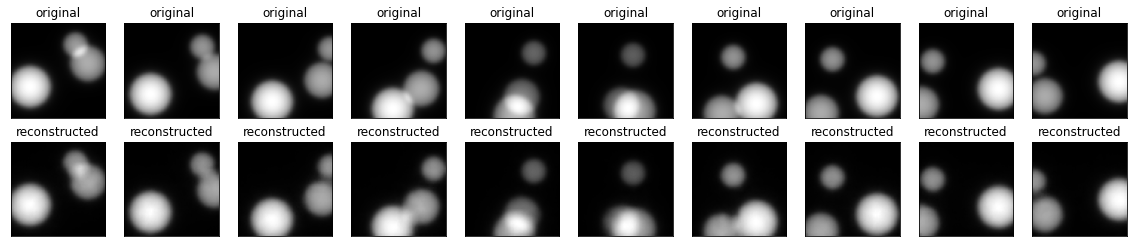

In [5]:
autoencoder = tf.keras.models.load_model('autoencoder_256')
#autoencoder = tf.keras.models.load_model('autoencoder_128')
#autoencoder = tf.keras.models.load_model('autoencoder_64')

n = sequence_length  # how many digits we will display
rand_sequence = 0#np.random.randint(len(x_val)/sequence_length)

seq_start = rand_sequence * sequence_length

org_frames = x_val[seq_start : seq_start + sequence_length]
encoded_imgs = autoencoder.encoder(org_frames).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.figure(figsize=(20, 4))
for i in range(sequence_length):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(tf.squeeze(org_frames[i]))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

**Task 2**

In [7]:
# Parameters
neck_width = 256

latent_dim = neck_width
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
filt_dim = latent_dim+2
seq_len = 9

In [8]:
autoencoder = tf.keras.models.load_model('autoencoder_256')
autoencoder.trainable = False
autoencoder.encoder.trainable = False
autoencoder.decoder.trainable = False

def create_model(neck_width):
    filt_dim = neck_width + 2

    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, filt_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, filt_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, filt_dim)

    in_seq = tf.keras.layers.Input(shape=(seq_len, neck_width))
    x = time_embedding(in_seq)
    x = tf.keras.layers.Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(latent_dim, activation='linear')(x)
    out = tf.keras.layers.LeakyReLU()(x)
    #out = autoencoder.decoder(x)

    model = tf.keras.Model(inputs=in_seq, outputs=out)
    #model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())
    return model

model = create_model(neck_width)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9, 256)]     0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 9, 2)         36          ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 9, 258)       0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 9, 258)      3313420     ['concatenate[0][0]',        

Data preperation

In [9]:
# encoded data
comp_train = autoencoder.encoder(x_train)
comp_val   = autoencoder.encoder(x_val)

# split data into sequences
print(comp_train.shape)
comp_train_reshaped = tf.reshape(comp_train,(800,sequence_length,neck_width))
comp_train_y_reshaped = tf.reshape(x_train,(800,sequence_length,64,64,1))

train_x = comp_train_reshaped[:,0:9,:]
train_y = comp_train_reshaped[:,9,:]
print(train_x.shape)
print(train_y.shape)
#plt.imshow(train_y[0,:])

comp_val_reshaped   = tf.reshape(comp_val,(200,sequence_length,neck_width))
comp_val_y_reshaped = tf.reshape(x_val,(200,sequence_length, 64,64,1))

val_x = comp_val_reshaped[:,0:9,:]
val_y = comp_val_reshaped[:,9,:]
#val_y = comp_val_y_reshaped[:,9,:]
print(val_x.shape)
print(val_y.shape)
#plt.imshow(train_y[0,:])
#plt.colorbar()

(8000, 256)
(800, 9, 256)
(800, 256)
(200, 9, 256)
(200, 256)


Training

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            min_delta=0,
                                            patience=3,
                                            verbose=1,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=True)
model.fit(train_x, train_y, 
                 batch_size=32,
                 epochs=500,
                 shuffle=True,
                 validation_data=(val_x, val_y)
                 )

model.save('transformer_encoder')

Epoch 1/500
25/25 [==============================] - 20s 245ms/step - loss: 1.0183 - val_loss: 0.8449
Epoch 2/500
25/25 [==============================] - 2s 95ms/step - loss: 0.8400 - val_loss: 0.8150
Epoch 3/500
25/25 [==============================] - 2s 95ms/step - loss: 0.8017 - val_loss: 0.8187
Epoch 4/500
25/25 [==============================] - 2s 95ms/step - loss: 0.7654 - val_loss: 0.7775
Epoch 5/500
25/25 [==============================] - 2s 96ms/step - loss: 0.7286 - val_loss: 0.7798
Epoch 6/500
25/25 [==============================] - 2s 95ms/step - loss: 0.6865 - val_loss: 0.7498
Epoch 7/500
25/25 [==============================] - 2s 96ms/step - loss: 0.6252 - val_loss: 0.6816
Epoch 8/500
25/25 [==============================] - 2s 96ms/step - loss: 0.5490 - val_loss: 0.5848
Epoch 9/500
25/25 [==============================] - 2s 96ms/step - loss: 0.4628 - val_loss: 0.4872
Epoch 10/500
25/25 [==============================] - 2s 97ms/step - loss: 0.4024 - val_loss: 0.46

INFO:tensorflow:Assets written to: transformer_encoder\assets


INFO:tensorflow:Assets written to: transformer_encoder\assets


Check prediction

In [10]:
model = tf.keras.models.load_model('transformer_encoder_ok')
autoencoder = tf.keras.models.load_model('autoencoder_256')

Training Set

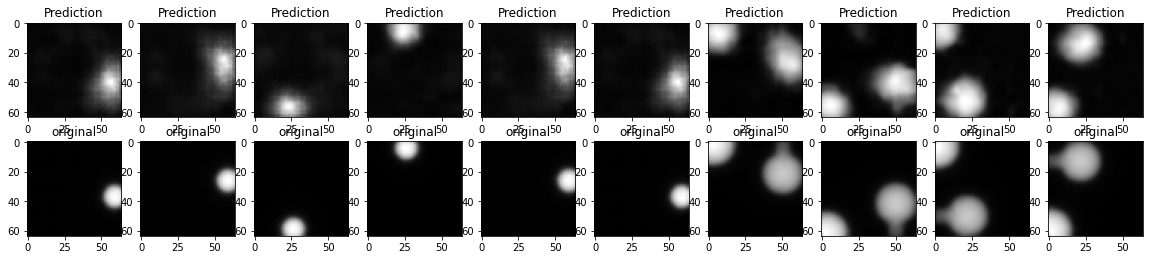

In [158]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    y_pred = model.predict(train_x[i:i+1])
    #print(tf.squeeze(autoencoder.decoder(y_pred)).shape)
    plt.subplot(2, n, i + 1)
    plt.title("Prediction")
    plt.imshow(tf.squeeze(autoencoder.decoder(y_pred)), cmap='gray')
    plt.subplot(2, n, i + 1 + n)
    a = tf.reshape(train_y[i],[1,256])
    #print(autoencoder.decoder(a).shape)
    plt.title("original")
    plt.imshow(tf.squeeze(autoencoder.decoder(a)), cmap='gray')

Validation Set

(9, 256)


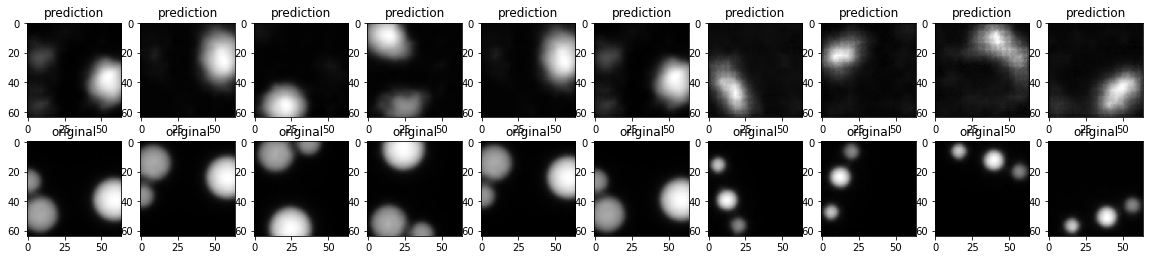

In [159]:
print(val_x[0].shape)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    #print(val_x[i:i+1].shape)
    y_pred = model.predict(val_x[i:i+1])
    #print(tf.squeeze(autoencoder.decoder(y_pred)).shape)
    plt.subplot(2, n, i + 1)
    plt.title("prediction")
    plt.imshow(tf.squeeze(autoencoder.decoder(y_pred)), cmap='gray')
    plt.subplot(2,n,i+1+n)
    a = tf.reshape(val_y[i],[1,256])
    #print(autoencoder.decoder(a).shape)
    plt.title("original")
    plt.imshow(tf.squeeze(autoencoder.decoder(a)), cmap='gray')


**LSTM**

In [11]:
def make_LSTM_model():
  in_seq = tf.keras.layers.Input(shape=(seq_len, latent_dim))
  x = tf.keras.layers.LSTM(neck_width*9)(in_seq)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  out = tf.keras.layers.Dense(latent_dim, activation='relu')(x)

  model = tf.keras.Model(inputs=in_seq, outputs=out)
  model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
  return model

lstm_model = make_LSTM_model()
lstm_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9, 256)]          0         
                                                                 
 lstm (LSTM)                 (None, 2304)              23602176  
                                                                 
 dropout_2 (Dropout)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                147520    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
Total params: 23,766,336
Trainable params: 23,766,336
Non-t

Train

In [12]:
lstm_model.fit(train_x, train_y,
                epochs=30,
                shuffle=True,
                batch_size=10,
                validation_data=(val_x, val_y)
)

Epoch 1/30
80/80 [==============================] - 33s 385ms/step - loss: 0.0744 - val_loss: 0.0606
Epoch 2/30
80/80 [==============================] - 30s 379ms/step - loss: 0.0512 - val_loss: 0.0409
Epoch 3/30
80/80 [==============================] - 31s 383ms/step - loss: 0.0372 - val_loss: 0.0299
Epoch 4/30
80/80 [==============================] - 30s 379ms/step - loss: 0.0297 - val_loss: 0.0241
Epoch 5/30
80/80 [==============================] - 30s 377ms/step - loss: 0.0248 - val_loss: 0.0213
Epoch 6/30
80/80 [==============================] - 30s 381ms/step - loss: 0.0220 - val_loss: 0.0191
Epoch 7/30
80/80 [==============================] - 30s 376ms/step - loss: 0.0187 - val_loss: 0.0192
Epoch 8/30
80/80 [==============================] - 30s 379ms/step - loss: 0.0174 - val_loss: 0.0173
Epoch 9/30
80/80 [==============================] - 31s 383ms/step - loss: 0.0160 - val_loss: 0.0173
Epoch 10/30
80/80 [==============================] - 30s 378ms/step - loss: 0.0147 - val_lo

KeyboardInterrupt: 

In [13]:
lstm_model.save('lstm')

INFO:tensorflow:Assets written to: lstm\assets


INFO:tensorflow:Assets written to: lstm\assets


Visualization

(9, 256)


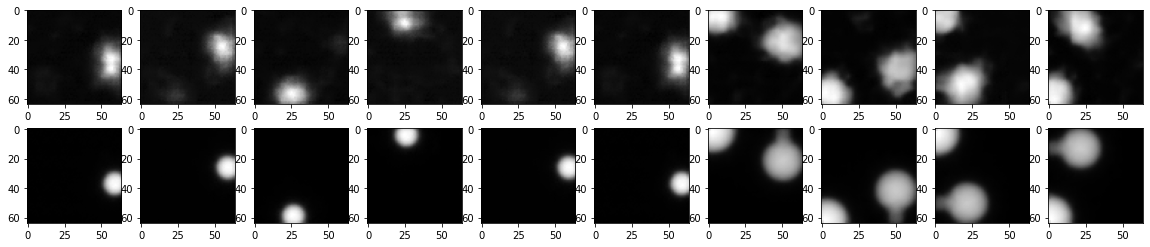

In [14]:
print(train_x[0].shape)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    y_pred = lstm_model.predict(train_x[i:i+1])
    #print(tf.squeeze(autoencoder.decoder(y_pred)).shape)
    plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(autoencoder.decoder(y_pred)), cmap='gray')
    plt.subplot(2,n,i+1+n)
    a = tf.reshape(train_y[i],[1,256])
    #print(autoencoder.decoder(a).shape)
    plt.imshow(tf.squeeze(autoencoder.decoder(a)), cmap='gray')